# Simulator sketch up

## Simulation type
1. Link-based
2. Vehicle based

## Data source:
1. Historical data as stream
2. Live data as stream

## Step 1: Imitate real-time trajectories
1. Set up route and stops (We dont care about the best practice right now)

## Step 2: Define update functions for simulation
1. update link travel speed
2. update dwelling information

# 1. Setup

In [1]:
import os
import sys
import csv
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as ss

import buskit as bk
from buskit import busdata as bdata
from buskit import dashboard as bdash
from buskit import simulator as bsim

from IPython.display import display, clear_output

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1.1 Global Functions

## 1.2 Global Parameters

In [4]:
# specify path to archive AVL file
archive_path = 'MTA_data/B15-180625-235941-44650-Mon.csv'
data = bsim.load_archive(archive_path, 1)

# determine data source
beta = False

time_coef = 100000 # simulation time is __ times faster than the reality
avg_door_t = 5 # assume opening and closing the door take 5 seconds in total
avg_board_t = 3 # assume each boarding takes 3 sec
avg_alight_t = 2 # assume each alight takes 2 sec

if beta:
    # artificial data   ### make this part automatized with given number of stop
    stop_ref = np.array([1, 2, 3, 4, 5, 6, 7])
    stop_pos = np.array([0, 100, 200, 300, 400, 500, 600])
    stop_name = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
else:
    # historical data
    stop_ref, stop_pos, stop_name = bsim.read_data(archive_path, 1)

# speed and travel time data are currently artificial
link_vel = 1.5 * np.random.randn(len(stop_pos)) + 7 # make sure the unit is m/sec
#dwell_t = 7 * np.random.randn(len(stop_pos)) + 20 # make sure the unit is sec

# pax distribution
stop_pos_next = np.append(stop_pos, stop_pos[-1])[1:]

pos_mu = stop_pos.mean()
pos_std = stop_pos.std()
pax_norm = ss.norm(loc=pos_mu, scale=pos_std)
pax_perc = np.array([pax_norm.cdf(stop_pos_next[i]) - pax_norm.cdf(stop_pos[i]) for i in range(len(stop_pos))]) ### a temporary measure ###

pax_hr_route = 5000
pax_hr_stop = pax_hr_route * pax_perc
pax_at_stop = np.zeros(len(stop_pos))

## 1.3 Classes

In [5]:
# Bus class
class Bus(object):
    
    capacity = 60
    seat = 40
    
    def __init__(self, ref, pos=0):
        self.ref = ref # vehicle reference
        self.pos = pos # vehicle location (1-D)
        
        ############### fix this: stop_pos, link, vel, next_stop should not require pre-specify, how? ##############
        
        self.link = np.sum(self.pos >= stop_pos) - 1 # link index starts from 0  ### unified with the formula in Stop Class
        self.vel = link_vel[self.link] # speed at current link
        self.next_stop = stop_pos[self.link + 1] # position of next stop
        self.dwell_t = 0
        self.pax = 0
        self.clock = 0
        self.operate = True
        self.atstop = False
        
        self.log_pos = [self.pos]
        self.log_vel = [self.vel]
        self.log_pax = [0]
        self.log_dwell = [0]

    def terminal(self):
        print("The bus has reached the terminal")
        self.operate = False
        self.vel = 0
        self.pax = 0
        
    def stop(self):
        print("Bus %s is making a stop at %s (position %i)"%(self.ref, stop_name[self.link + 1], self.next_stop))
        self.atstop = True
        self.pax_to_board = pax_at_stop[self.link + 1] # check how many pax at stop
        self.board_t = self.pax * avg_board_t
        self.alight_t = 0 * avg_alight_t  #### TO DEVELOP
        self.dwell_t = avg_door_t + self.alight_t + self.board_t # supposed to dwell for this long
        self.clock += 1

#         self.vel = 0
#         self.pos += self.vel
        self.record()

    def move(self):
        pax_at_stop[self.link + 1] = 0 # clear all pax at stop
        self.log_dwell.append(self.dwell_t)
        # move on!
        self.atstop = False
        self.dwell_t = 0
        self.clock = 0
        self.link += 1
        self.pax = 0 # update pax onboard ###################
        self.record()
        self.vel = link_vel[self.link] # new link speed
        self.next_stop = stop_pos[self.link + 1] # new next stop

    def record(self):
        self.log_pos.append(self.pos)
        self.log_pax.append(self.pax)
        
    def proceed(self):
        if self.operate:
            if self.pos + self.vel >= stop_pos[-1]:
                self.terminal()
            elif self.pos + self.vel >= self.next_stop:  ### this judgement restricts from recording vel as 0 at stop, change to sth else
                self.stop()
                if self.clock >= self.dwell_t:
                    self.move()
            else:
                print("Current position of bus %s: %i"%(self.ref, self.pos))
                self.pos += self.vel
                self.record()
        else:
            print("Bus %s is not operating."%(self.ref))

# 2. Simulation Environment
## 2.1 Route Setup

## 2.2 Stream Archive

In [6]:
# create empty dicts and lists
live_bus = {}
dwell_time = {}
travel_speed = {}

In [7]:
# df = pd.read_csv(archive_path)
# bdata.plot_tsd(df, 1, 0, 30)

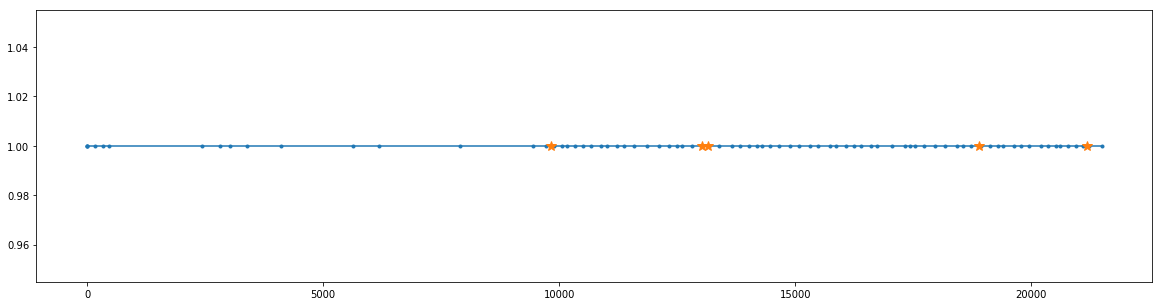

Time elapsed: 19.0 minutes


KeyboardInterrupt: 

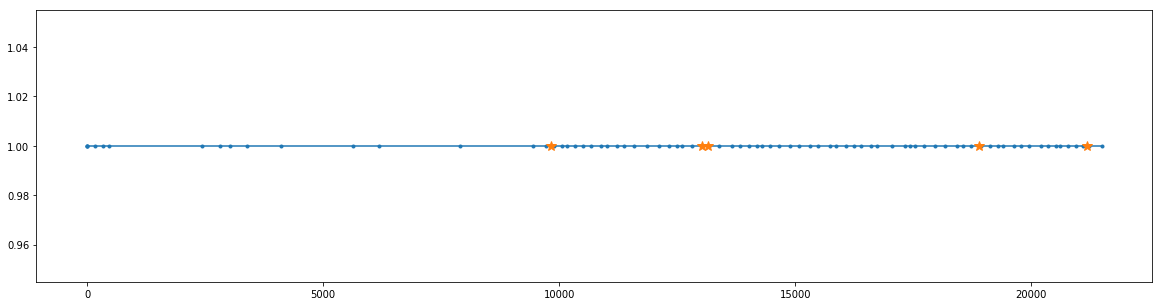

In [8]:
data = bsim.load_archive(archive_path, 1)
bus_pos = [bus.pos for bus in live_bus.values()]

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)

ax.plot(stop_pos, np.ones(len(stop_pos)), '.-')
vehs, = ax.plot(bus_pos, np.ones(len(bus_pos)), '*', markersize=10)

clock = 0
while True:
    bsim.stream_next(data, live_bus)
    bus_pos = [bus.pos for bus in live_bus.values()]
    vehs.set_data(bus_pos, np.ones(len(bus_pos)))

    clear_output(wait=True)
    display(fig)
    print("Time elapsed: %s minutes"%(clock * 0.5))

    clock += 1
    time.sleep(1) # set a global time equivalent parameter

In [ ]:

batch = next(data)
batch[0]

In [ ]:
def update_bus(new, ref, pos):
    
#     # check previous status
#     # previously at a stop
# 	if live_bus[ref]['PresentableDistance'] == 'at_stop':
#         # bus left stop: update dwelling info
#         ########## CAVEAT: AT THE SAME STOP? ##########
# 		if new['PresentableDistance'] != 'at_stop':
# 			update_dwell()
#         # bus still at stop: no action required
# 		else:
# 			pass
            
#     # previously traveling
# 	else:
#         # bus made a stop: prepare dwelling info
# 		if new['PresentableDistance'] == 'at_stop':
#             make_stop()
#         # bus still traveling: upodate link speed
# 		else:
# 			update_speed()
    
    for bus in live_bus.values():
        if bus.ref == ref:
            bus.pos = pos

# for bus in batch_stream:
# 	if bus not in live_bus:
#         live_bus.append(bus)
# # 		heap.append(live_bus, bus)
# 	else:
# 		update_bus(bus)
# 		update_link(bus)


# missing pings?

# exclude terminal one or two stops


def update_speed():
	rolling_window
# missing pings?